In [ ]:
#####################################################################################################
# Author: Stefano Fernando Panzeri Reyes                                                            #
# Master Thesis: Data Analysis and Modelling of Induction Hardening Processes                       #
# Collaborators: USN and ENRX                                                                       #
# Year: 2023                                                                                        #     
# License: MIT License (see the LICENSE file for the full license text)                             #
# Python Version: 3.10                                                                              #             
# Description: Development of an LSTM model for error prediction.                                   #
#              - Data selection and preparation                                                     #
#              - Prediction of DC Voltage Too Low by analysing the lat 10 seconds of hardening of   # 
#                the previous 5 hardening processes.                                                #
#####################################################################################################

RELEVANT IMPORTS

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

DATA SELECTION

Import and Sorting of Data from the General Client Dictionary

In [2]:
# Select Client, Job and Error to indentify 
client = 'Client2'
job = 'Job4'
errorToPredict = 2048  # DC Voltage Too Low
# Folder with Client Data filtered in pickle format
pickle_folder = os.path.join(os.getcwd(),'DATA/PickleData_Filtered')
# Import Dictionary containing individual workpieces for Client 2
dictionary = pickle.load(open(os.path.join(pickle_folder, client, 'dictionary_df_' + client + '.pickle'), 'rb'))

# Select the variables to use (according to previous analysis) - HeatingCycleTime only in use for selection (not in model development):
variablesToUse = ["Counter", "HeatingCycleTime", "Converter_Power", "Converter_DC_Voltage", "Converter_AC_Current", "Converter_Frequency", "Converter_Error"]

# Extract and sort the keys of general Client dictionary (key starts with timestamp)
keys = list(dictionary.keys())
keys.sort()
dictionary_sorted = {i: dictionary [i] for i in keys}  # Create a sorted dictionary to use

# Get keys position of the different groups of interest
indexes_NoErrors = []
indexes_ErrorsOfInterest = []
indexes_ConverterOff = []
for key in dictionary_sorted:  # Iterate the dictionary key by key (file by file)
    df = dictionary_sorted[key]  # Import the df
    # Some dataframes do not have an error but the Power was never turned on. These should not be considered.
    converterPower = df['Converter_Power']  # get Converter Power values
    power = list(converterPower[converterPower != 0])  # Get only those different from 0 (to see if converter was ON)
    heatingCycle = df['HeatingCycleTime'].max()  # Get Total Heating Cycle Time for the workpiece
    
    if len(power) <= 0 or heatingCycle < 10: # From the general dictionary, set in a special list the keys that have a heating cycle of less than 10 seconds
        indexes_ConverterOff.append(keys.index(key))
    
    if key[25:] == job:  # Analyse workpieces for the job of interest
        converterError = (df['Converter_Error'])     # Extract the list of all converter errors in the file
        errors = list(converterError[converterError != 0]) # Get only those different from 0
        unique_errors = list(set(errors))  # Filter to remove duplicates
        if len(unique_errors) > 0: # Attach to dictionary if error of interest is present
            if errorToPredict in unique_errors: 
                indexes_ErrorsOfInterest.append(keys.index(key))
        else:  # Attach to dictionary if no error is present and Power was ON
            if len(power) > 0 and heatingCycle >= 10:
                indexes_NoErrors.append(keys.index(key))

Creation of 5-workpieces groups

In [3]:
# Getting 5 previous indexes for both error files and non-error files

# ERROR FILES
indexes_ErrorGrouped = []  # List of List containing the 5-workpieces groups
tempList = []  # Temporary ist containing 5 indexes of interest
for i in indexes_ErrorsOfInterest: # Get 5 previous files that do not have power OFF
    element = i  # Get error index from List
    while len(tempList) < 5:  # Find indexes until the group of 5 is completed
        element = element-1  # Get the previous index
        if element not in indexes_ConverterOff:  # Append only if that index is not present in the Converter Off list
            tempList.append(element)
    indexes_ErrorGrouped.append(tempList) # Append list of 5 to general list of list
    tempList = []  # Reset temporary list
    
# NON-ERROR FILES  
indexes_NoErrorGrouped = []  # List of List containing the 5-workpieces groups
tempList = []  # Temporary ist containing 5 indexes of interest
for i in indexes_NoErrors: # 5 consecutive non-error files within Job 4
    if len (tempList) == 0:  # Append first element to list if this is empty
        tempList.append(i)
    elif len(tempList) == 5:  # If list has 5 elements
        if i == tempList[len(tempList)-1]+1: # Append index if this is consecutive to the lat index in the list
            indexes_NoErrorGrouped.append(tempList)  # Append list of 5 to general list of list
            tempList = [] # Empty list for next group
        else:   # If not, empty list and start again
            tempList = []
    else:  # 
        if i == tempList[len(tempList)-1]+1: # Append index if this is consecutive to the lat index in the list
            tempList.append(i)
        else:  # If not, empty list and start again
            tempList = []

In [4]:
print(len(indexes_NoErrorGrouped))
print(len(indexes_ErrorGrouped))

174
8


DATA PREPARATION

Splitting of indexes in relevant indexes lists for ML

In [5]:
# Split lists of indexes

random.seed(21) # Set random for always have the same datasets

# NON-ERROR WORKPIECES
# 70% to train (122), 20% to validation (35) and 10% to testing (17)
train_indexes_NoError= random.sample(indexes_NoErrorGrouped, 122)  # Extract 122 random non-error indexes for training
remaining_indexes_NoError = [i for i in indexes_NoErrorGrouped if i not in train_indexes_NoError]  # Filter the original list with the remaining entries
validation_indexes_NoError = random.sample(remaining_indexes_NoError, 35)   # Extract 33 random non-error indexes for validation
test_indexes_NoError = [i for i in remaining_indexes_NoError if i not in validation_indexes_NoError]  # Extract the non-error testing indexes from filtering the list with the remaining entries

# ERROR WORKPIECES
# 60% to train (4) , 20% to validation (2) and 20% to testing (2)
train_indexes_Error= random.sample(indexes_ErrorGrouped, 4) # Extract 4 random error indexes for training
remaining_indexes_Error = [i for i in indexes_ErrorGrouped if i not in train_indexes_Error]   # Filter the original list with the remaining entries
validation_indexes_Error = random.sample(remaining_indexes_Error, 2)  # Extract 2 random error indexes for validation
test_indexes_Error = [i for i in remaining_indexes_Error if i not in validation_indexes_Error] # Extract the error testing indexes from filtering the list with the remaining entries

Extraction of dictionaries based on key's indices and creation of ML arrays

In [6]:
# Pack into arrays for X and Y training sets and get the last 10 seconds (50 samples)
# Comments made only on TRAIN, same procedure applies for VALIDATION and TEST

# Final list to variables to use for ML development.
variablesToUse_final = ["Counter", "Converter_Power", "Converter_DC_Voltage", "Converter_AC_Current", "Converter_Frequency", "Converter_Error"]

# TRAIN
x_train = []
y_train = []
for group in train_indexes_NoError:  # Iterate over the list of lists containing the 5-workpieces groups for non-error workpieces
    df_group= []  # List containing the df subsets for each index in the group
    for index in group:    
        df = list(dictionary_sorted.items())[index][1][variablesToUse_final]  # Extract the dictionary for the selected key with the relevant variables
        for index, row in df.iloc[::-1].iterrows():  # Iterate from bottom for last Power OFF
            if row['Converter_Power'] > 0:  # Get row when Converter was ON last time ON
                break
        subset_df = df.iloc[index-49:index+1]  # Get previous 50 samples
        df_group.append(subset_df)  # Add the subset of the dataframe for that index, to the general list for that group
    stacked_group = np.stack([df.values for df in df_group], axis=0) # Stack the df subsets of that group (having 5 df per group)
    x_train.append(stacked_group)  # Append the array into the X train list
    y_train.append(False) # The label for this data is false (No Error)

for group in train_indexes_Error:   # Iterate over the list of lists containing the 5-workpieces groups for error workpieces
    df_group= []  # List containing the df subsets for each index in the group
    for index in group:    
        df = list(dictionary_sorted.items())[index][1][variablesToUse_final]  # Extract the dictionary for the selected key with the relevant variables
        for index, row in df.iloc[::-1].iterrows():  # Iterate from bottom for last Power OFF
            if row['Converter_Power'] > 0:  # Get row when Converter was ON last time ON
                break
        subset_df = df.iloc[index-49:index+1]   # Get previous 50 samples
        df_group.append(subset_df)  # Add the subset of the dataframe for that index, to the general list for that group
    stacked_group = np.stack([df.values for df in df_group], axis=0)  # Stack the df subsets of that group (having 5 df per group)
    for i in range(10):  # Duplicate 10 times fail data (append the same 10 times)
        x_train.append(stacked_group)   # Append the array into the X train list
        y_train.append(True)   # The label for this data is True (Error)

# Pack lists into array format
x_train = np.array(x_train)
y_train = np.array(y_train)


# VALIDATION
x_validation = []
y_validation = []
for group in validation_indexes_NoError:
    df_group= []
    for index in group:    
        df = list(dictionary_sorted.items())[index][1][variablesToUse_final]
        for index, row in df.iloc[::-1].iterrows():
            if row['Converter_Power'] > 0:
                break
        subset_df = df.iloc[index-49:index+1]
        df_group.append(subset_df)
    stacked_group = np.stack([df.values for df in df_group], axis=0)
    x_validation.append(stacked_group)
    y_validation.append(False)    

for group in validation_indexes_Error:
    df_group= []
    for index in group:    
        df = list(dictionary_sorted.items())[index][1][variablesToUse_final]
        for index, row in df.iloc[::-1].iterrows():
            if row['Converter_Power'] > 0:
                break
        subset_df = df.iloc[index-49:index+1]
        df_group.append(subset_df)
    stacked_group = np.stack([df.values for df in df_group], axis=0)
    for i in range(10):
        x_validation.append(stacked_group)
        y_validation.append(True)    

x_validation = np.array(x_validation)
y_validation = np.array(y_validation)


# TEST
x_test = []
y_test = []
for group in test_indexes_NoError:
    df_group= []
    for index in group:    
        df = list(dictionary_sorted.items())[index][1][variablesToUse_final]
        for index, row in df.iloc[::-1].iterrows():
            if row['Converter_Power'] > 0:
                break
        subset_df = df.iloc[index-49:index+1]
        df_group.append(subset_df)
    stacked_group = np.stack([df.values for df in df_group], axis=0)
    x_test.append(stacked_group)
    y_test.append(False)    

for group in test_indexes_Error:
    df_group= []
    for index in group:    
        df = list(dictionary_sorted.items())[index][1][variablesToUse_final]
        for index, row in df.iloc[::-1].iterrows():
            if row['Converter_Power'] > 0:
                break
        subset_df = df.iloc[index-49:index+1]
        df_group.append(subset_df)
    stacked_group = np.stack([df.values for df in df_group], axis=0)
    for i in range(10):
        x_test.append(stacked_group)
        y_test.append(True)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [7]:
# Print shapes of the 6 created arrays
print('X Train:',x_train.shape)
print('Y Train:', y_train.shape)
print('X Validation:', x_validation.shape)
print('Y Validation:', y_validation.shape)
print('X Test:', x_test.shape)
print('Y Test:', y_test.shape)

X Train: (162, 5, 50, 6)
Y Train: (162,)
X Validation: (55, 5, 50, 6)
Y Validation: (55,)
X Test: (37, 5, 50, 6)
Y Test: (37,)


Shuffling of data within the arrays (to not have all the errors together)

In [8]:
# Shuffle data over the first dimension of the array so that the errors are not all together
# Comments made only on TRAIN, same procedure applies for VALIDATION and TEST

# TRAIN
permutation_index = np.random.permutation(len(x_train))  # Generate a common permutation index
# Apply the same permutation to both arrays. Apply also formatting.
x_train = np.array([x_train[i] for i in permutation_index]).astype(float)
y_train = np.array([y_train[i] for i in permutation_index]).astype(int)

# VALIDATION
permutation_index = np.random.permutation(len(x_validation))
x_validation = np.array([x_validation[i] for i in permutation_index]).astype(float)
y_validation = np.array([y_validation[i] for i in permutation_index]).astype(int)

# TEST
permutation_index = np.random.permutation(len(x_test))
x_test = np.array([x_test[i] for i in permutation_index]).astype(float)
y_test = np.array([y_test[i] for i in permutation_index]).astype(int)

Standardization of Data

In [9]:
def transformation(data4d):
    """
    :param data4d: Data to Standardize
    :return: Standardized Data
    """
    data2d = data4d.reshape(-1,data4d.shape[-1])  # Reshape the data into a 2D array to apply Standardization Function
    standardize = StandardScaler().fit(data2d)  # Import and adapt StandardScaler() function do data shape
    standardized_features2d = standardize.transform(data2d)  # Standardize data with StandardScaler() function
    standardized_features4d = standardized_features2d.reshape(data4d.shape)  # Reshape the data again into a 4D array
    return standardized_features4d

# Apply Standardization to the three X arrays
x_train_transformed=transformation(x_train)
x_validation_transformed=transformation(x_validation)
x_test_transformed=transformation(x_test)

In [10]:
# Print difference between original data and Standardize Data.
print('X Train First sample of First Element (non-scaled):', x_train[0][0][0])  # First Row of First Sample in First Group in array.
print('X Train First sample of First Element (scaled):', x_train_transformed[0][0][0])  # First Row of First Sample in First Group in array.

X Train First sample of First Element (non-scaled): [555.     128.3517 503.0769 636.0439   6.7155   0.    ]
X Train First sample of First Element (scaled): [ 0.2982066   2.61412233 -1.74166081  1.78508094 -0.66596871  0.        ]


Saving ML Vectors

In [11]:
saving_folder = os.path.join(os.getcwd(),'LSTM_Files/LSTMVectors/Case2')
os.makedirs(saving_folder, exist_ok=True)  # Create directory if it does not exist
np.save(os.path.join(saving_folder,'x_trainCase2_transformed'),x_train_transformed)
np.save(os.path.join(saving_folder,'y_trainCase2'),y_train)
np.save(os.path.join(saving_folder,'x_validationCase2_transformed'),x_validation_transformed)
np.save(os.path.join(saving_folder,'y_validationCase2'),y_validation)
np.save(os.path.join(saving_folder,'x_testCase2_transformed'),x_test_transformed)
np.save(os.path.join(saving_folder,'y_testCase2'),y_test)

MODEL DEVELOPMENT

Definition of Relevant Functions

In [47]:
def model_setup(num_hidden_layers, num_neurons, activation_function, input_shape, output_shape):
    """
    Function to create a dynamic LSTM model, according to input parameters
    
    :param num_hidden_layers: Integer number of hidden layers (not counting input and output layer)
    :param num_neurons:  List containing number of neurons per layer
    :param activation_function: String containing activation function name for hidden layers
    :param input_shape: List containing th shape of input
    :param output_shape: List containing th shape of output
    :return: Compiled Sequential LSTM model
    """
    # Definition of model metrics
    precision = keras.metrics.Precision(name='precision')
    recall = keras.metrics.Recall(name='recall')
    
    model_LSTM = Sequential()  # Creation of empty Keras Sequential Model
    for i in range(num_hidden_layers):  # Iterate over number of hidden layers
        # Neurons in each layer are according to the number of the layer
        if i == 0: # First layer must have input shape and Return Sequences to True
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function,input_shape=(input_shape[1],input_shape[2]), return_sequences=True))
        elif i == num_hidden_layers -1: # Last layer must have Return Sequences to False (no need to output all the hidden states)
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function))
        else: # Middle layers have Return Sequences to True
            model_LSTM.add(LSTM(units=num_neurons[i], activation=activation_function,return_sequences=True))

    model_LSTM.add(Dense(units = output_shape[1], activation='sigmoid')) # Dense layer output with Sigmoid as Activation Function (binary classification)
    model_LSTM.compile(optimizer='adam', loss='mse', metrics=[precision, recall])  # Compiling using adam, Mean Square Error as loss and the two defined metrics
    return model_LSTM


def plot_training(history, type_graph, saving=False, saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case2')):
    """
    Function to Plot the Performance Metric during the training of the model
    
    :param history: Object variable containing history from model training
    :param type_graph: String with metric to plot
    :param saving: Boolean value indicating if needed to save the created figure 
    :param saving_path: String indicating the path to save the created figure
    :return: NO RETURN
    """
    fig = plt.figure()  # create new figure
    plt.plot(history.epoch,history.history[type_graph])  # Plot the history of the selected metric for training dataset
    plt.plot(history.epoch,history.history['val_' + type_graph])  # Plot the history of the selected metric for validation dataset (in same figure)
    plt.legend(['Training Set', 'Validation Set'])  # Legend to indicate which curve correspond to each dataset
    # Add corresponding labels
    plt.ylabel(type_graph + ' score')
    plt.xlabel('epoch')
    # Add title according to the metric plotted
    name= 'Model ' + type_graph 
    plt.title(name)
    if saving:  # Saving figure locally
        os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
        fig.savefig(os.path.join(saving_path, name +  ' Case 2.png'), format='png', dpi=600, transparent=True)
    plt.show()
    
def plot_prediction(y_predicted, y_test, saving=False, saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case2')):
    """ 
    Function to Plot the Predictions made by the model against the real targets
    
    :param y_predicted: List containing predicted values
    :param y_test: List containing target values (test dataset)
    :param saving: Boolean value indicating if needed to save the created figure 
    :param saving_path: String indicating the path to save the created figure
    :return: NO RETURN
    """
    fig = plt.figure() # create new figure
    plt.plot(y_test, '-o') # Plot the real targets 
    plt.plot(y_predicted, '--*')  # Plot the predicted values with a dotted line
    plt.legend(['Target Values','Predicted Values']) # Legend to indicate which curve correspond to each variable
    # Add corresponding labels
    plt.ylabel('Presence of Error')
    plt.xlabel('Samples')
    # Add title according to the metric plotted
    name= 'Prediction on Test data'
    plt.title(name)
    if saving: # Saving figure locally
        os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
        fig.savefig(os.path.join(saving_path, name +  ' Case 2.png'), format='png', dpi=600, transparent=True)
    plt.show()

In [13]:
tf.get_logger().setLevel('ERROR')  # Avoid TensorFlow output during training if not an error

# Create dictionary with model parameters to test
model_parameters_grid = {
    'num_hidden_layers': [2,3,4],
    'num_neurons': {    '2layers':[ [4,2], [5,3], ] ,
                        '3layers':[ [4,3,2], [5,4,3] ],
                        '4layers':[ [4,3,3,2], [5,3,2,2] ]
                    },
    'activation_functions': ['relu', 'sigmoid']
}

# Create lists with training parameters to test
epochs =  range(50,201,50)
batch_sizes = range(20,101,20)

estimator_results = {}  # Create empty dictionary containing result of every model
best_f1Score = 0  # Value to compare the F1 Score of each model and save the best one
best_recall = 0  # Value to compare the Recall Score of each model and save the best one
best_modelName_f1Score = ""   # Value to save the name of the model with the best F1 Score
best_modelName_recall = ""  # Value to save the name of the model with the best Recall Score
model_num = 0  # Model number to create Model name when this is created

# Packing of Input Data into a 3D Shape for ML training
x_train_transformed_3d = x_train_transformed.reshape(x_train_transformed.shape[0],-1,x_train_transformed.shape[-1])
x_validation_transformed_3d = x_validation_transformed.reshape(x_validation_transformed.shape[0],-1,x_validation_transformed.shape[-1])

# 5 nested for-loops for training to evaluate all model and training parameters combinations (from less to higher complexity)
for num_hidden_layers in model_parameters_grid['num_hidden_layers']:
    for num_neurons in model_parameters_grid['num_neurons'][str(num_hidden_layers)+'layers']:
        for activation_function in model_parameters_grid['activation_functions']:
            for epoch in epochs:
                for batch_size in batch_sizes:
                    model_name = 'model'+str(model_num) +'_'+str(epoch)+'_'+str(batch_size)   # create model name based on model config and training config
                    model = model_setup(num_hidden_layers, num_neurons, activation_function, list(x_train_transformed_3d.shape),[y_train.shape[0], 1])  # get compiled model according to the selected configuration
                    history = model.fit(x_train_transformed_3d, y_train,  epochs=epoch, batch_size= batch_size, verbose=0, validation_data=(x_validation_transformed_3d, y_validation), shuffle = False) # Train the model with training and validation data, with the corresponding training parameters
                    
                    # Get last value of precision and recall for validation
                    last_recall = history.history['val_recall'][-1]
                    last_precision = history.history['val_precision'][-1]
                    # Evaluate Recall Score with the previous best saved
                    if last_recall > best_recall:  # If better than the one saved
                        best_recall = last_recall  # Update best recall score
                        best_modelName_recall = model_name  # Update model name with best recall score
                        
                    # Calculate last value of F1 Score for validation
                    try:
                        f1_score = 2 * last_recall * last_precision / (last_recall + last_precision)
                    except ZeroDivisionError:  # Take into account the possibility that precision and recall are 0, and assign a 0 to F1 Score too
                        f1_score = 0
                    # Evaluate F1 Score with the previous best saved
                    if f1_score > best_f1Score:  # If better than the one saved
                        best_f1Score = f1_score  # Update best F1 score 
                        best_modelName_f1Score = model_name  # Update model name with best F1 score
                    
                    # Save in general dictionary the relevant parameters for the model trained
                    estimator_results[model_name] = {'model': model, 'history': history, 'f1_score': f1_score, 'epochs': epoch, 'batch_size': batch_size}
            
            # Print (for progress info) when one model configuration has been tested with all the different training parameters configurations
            print('Model ' + str(model_num) + ': DONE')  
            model_num +=1  # Increment model number for next model configuration
            
# get the dictionary containing the best F1 Score and Recall model, based on its name
best_model_F1Score = estimator_results[best_modelName_f1Score]
best_model_Recall = estimator_results[best_modelName_recall]

Model 0: DONE
Model 1: DONE
Model 2: DONE
Model 3: DONE
Model 4: DONE
Model 5: DONE
Model 6: DONE
Model 7: DONE
Model 8: DONE
Model 9: DONE
Model 10: DONE
Model 11: DONE


Saving Best Models in pickle format (model is not json serializable)

In [14]:
# saving_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case2')
# os.makedirs(saving_path, exist_ok=True)  # Create directory if it does not exist
# with open(os.path.join(saving_path, 'best_model_F1Score_Case2.pickle'), 'wb') as f:
#     pickle.dump(best_model_F1Score, f)
# with open(os.path.join(saving_path, 'best_model_Recall_Case2.pickle'), 'wb') as f:
#     pickle.dump(best_model_Recall, f)

Import saved models to be evaluated on test data (if training does not want to be executed again)

In [41]:
importing_path=os.path.join(os.getcwd(),'LSTM_Files/Results/Case2')
best_model_F1Score = pickle.load(open(os.path.join(importing_path, 'best_model_F1Score_Case2.pickle'), 'rb'))
best_model_Recall = pickle.load(open(os.path.join(importing_path, 'best_model_Recall_Case2.pickle'), 'rb'))

Models' Structure

In [42]:
# Get model structure and training parameters of the best F1 Score Model
print('BEST F1 SCORE MODEL')
print('\nRelevant model parameters:', dict(filter(lambda item: item[0] in ['f1_score', 'epochs', 'batch_size'], best_model_F1Score.items())))  # Get only specific keys from dictionary
print('\nModel Summary:')
best_model_F1Score['model'].summary()  # Keras Model summary of structure
print('\nModel structure:')
for i in range(len(best_model_F1Score['model'].layers)):  # Iterate over number of layers
    # Print number of neurons and activation function per layer
    print('Layer ' + str(i +1)+ ':' ,best_model_F1Score['model'].get_layer(index=i).get_config()['units'], 'neurons;',
    'Activation Function =',best_model_F1Score['model'].get_layer(index=i).get_config()['activation'])

BEST F1 SCORE MODEL

Relevant model parameters: {'f1_score': 0.9302325418280418, 'epochs': 200, 'batch_size': 80}

Model Summary:
Model: "sequential_298"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_836 (LSTM)             (None, 250, 5)            240       
                                                                 
 lstm_837 (LSTM)             (None, 3)                 108       
                                                                 
 dense_298 (Dense)           (None, 1)                 4         
                                                                 
Total params: 352 (1.38 KB)
Trainable params: 352 (1.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model structure:
Layer 1: 5 neurons; Activation Function = relu
Layer 2: 3 neurons; Activation Function = relu
Layer 3: 1 neurons; Activation Function = si

In [43]:
# Get model structure and training parameters of the best Recall Score Model
print('BEST RECALL SCORE MODEL')
print('\nRelevant model parameters:', dict(filter(lambda item: item[0] in ['f1_score', 'epochs', 'batch_size'], best_model_Recall.items())))  # Get only specific keys from dictionary
print('\nModel Summary:')
best_model_Recall['model'].summary()  # Keras Model summary of structure
print('\nModel structure:')
for i in range(len(best_model_Recall['model'].layers)):  # Iterate over number of layers
    # Print number of neurons and activation function per layer
    print('Layer ' + str(i +1)+ ':' ,best_model_Recall['model'].get_layer(index=i).get_config()['units'], 'neurons;',
    'Activation Function =',best_model_Recall['model'].get_layer(index=i).get_config()['activation'])

BEST RECALL SCORE MODEL

Relevant model parameters: {'f1_score': 0.5333333449893527, 'epochs': 150, 'batch_size': 100}

Model Summary:
Model: "sequential_274"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_788 (LSTM)             (None, 250, 4)            176       
                                                                 
 lstm_789 (LSTM)             (None, 2)                 56        
                                                                 
 dense_274 (Dense)           (None, 1)                 3         
                                                                 
Total params: 235 (940.00 Byte)
Trainable params: 235 (940.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Model structure:
Layer 1: 4 neurons; Activation Function = sigmoid
Layer 2: 2 neurons; Activation Function = sigmoid
Layer 3: 1 neurons; Activ

MODEL PERFORMANCE AND EVALUATION

Analysis of Model Performance

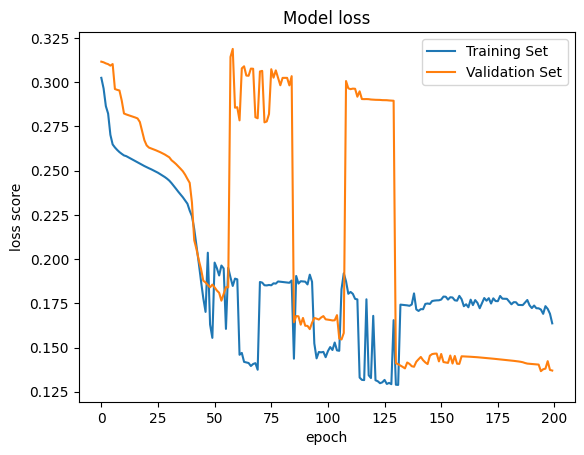

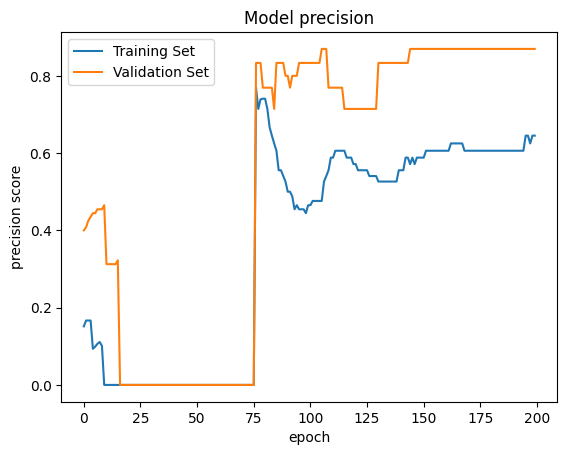

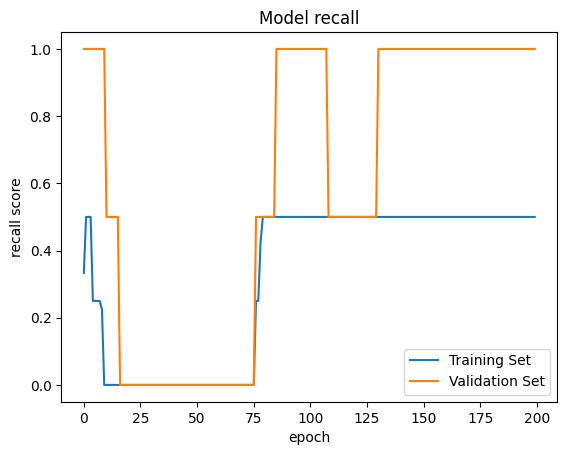

In [44]:
# Plots Performance Metrics during training and validation
history= best_model_F1Score['history']  # Get history object from dictionary
# Plot the loss and two metrics using the appropriate function
plot_training(history, type_graph='loss', saving=False)
plot_training(history, type_graph='precision', saving=False)
plot_training(history, type_graph='recall', saving=False)

Model evaluation over testing data

2/2 [==============================] - 0s 22ms/step


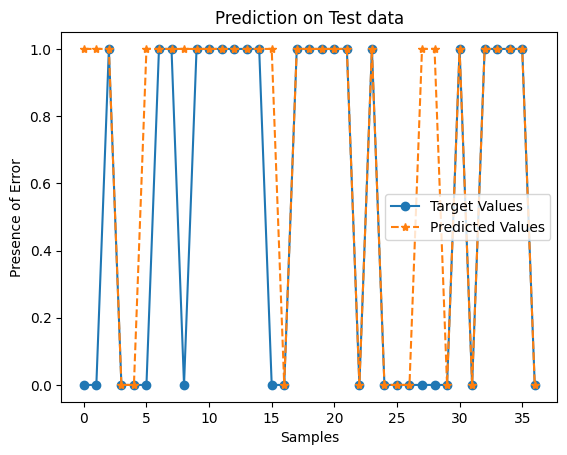

In [51]:
x_test_transformed_3d = x_test_transformed.reshape(x_test_transformed.shape[0],-1,x_test_transformed.shape[-1])  # Packing of Input Data into a 3D Shape
y_predicted_signal = best_model_F1Score['model'].predict(x_test_transformed_3d)  # Get model predictions ove testing data
# Optimal threshold evaluation
right_predictions = 0  # variable to calculate the right predictions made by the model
for i in range(0, 100, 5): # evaluate thresholds between 0 and 1 with intervals of 0.05
    y_predicted = []  # List of binary predictions
    for j in range(len(y_predicted_signal)): # Iterate over the number of predictions made
        # Apply threshold
        if y_predicted_signal[j] > i/100:  
            y_predicted.append(1)
        else:
            y_predicted.append(0)
    # Evaluate how many right predictions are made (TP + TN)
    # Compare results with last obtained results
    if sum(y_predicted == y_test) > right_predictions: # If better
        right_predictions = sum(y_predicted==y_test)  # Update number of right predictions
        threshold = i/100  # Update threshold value
        
# Final list is obtained by filtered the predicted signal with the optimal obtained threshold
for j in range(len(y_predicted_signal)):
        if y_predicted_signal[j] > threshold:
            y_predicted [j] = 1
        else:
            y_predicted[j] = 0
            
# Plot the predictions and two metrics using the appropriate function
plot_prediction(y_predicted, y_test, saving=False)

In [49]:
# Print the obtained threshold and the number of right predictions made
print('Threshold:', threshold)
print('Correct Predictions:',sum(y_predicted == y_test))

Threshold: 0.25
Correct Predictions: 30


In [50]:
# Evaluate final performance over test data
f1_score_test = keras.metrics.F1Score()  # Import F1 Score metric from Keras
precision_test = keras.metrics.Precision()  # Import Precision Score metric from Keras
recall_test = keras.metrics.Recall()  # Import Recall Score metric from Keras
# Update the metrics giving as input the target and predicted arrays in a 2D shape
f1_score_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
precision_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
recall_test.update_state(np.array(y_test.astype(int)).reshape(-1,1),np.array(y_predicted).reshape(-1,1))
# Print Results
print('Testing F1 Score: ', f1_score_test.result().numpy()[0])
print('Testing Precision: ', precision_test.result().numpy())
print('Testing Recall: ', recall_test.result().numpy())

Testing F1 Score:  0.8510638
Testing Precision:  0.7407407
Testing Recall:  1.0
